# Read Like You Tweet

## A New York Times Article Recommendation System Based On Your Twitter Timeline

### http://readlikeyoutweet.herokuapp.com/

#### Author: Karsten Kreis
#### September 2015

### 1. Introduction & Motivation

Every day, thousands of news articles are published on all kinds of different topics. These range from the latest political developments, over sports events, to the happenings in the arts and fashion world. Most people neither have the time to read all of this, nor would they be interested in it. This raises the question, how to find what is interesting for me? Of course, one can simply dig though all the media out there. Furthermore, most of us have our favorite websites, blogs and newspapers that we consume regularly because they usually publish the things that interest us.

Alternatively, it would be very handy to obtain personal and individualized recommendations of articles that we will most probably find interesting. However, what could such recommendations be based on? Each recommendation system needs some kind of input data. An example would be LinkedIn. Based on your profile data you get recommended individual and personalized collections of job ads.

Another data source, which is public and could be employed, is Twitter data. In this work, I aim to build a recommendation engine, "Read Like You Tweet", which recommends New York Times (NYT) articles to Twitter users based on what they have tweeted in the past. I have chosen Twitter data as input for the recommender, since it's easily obtainable - it's public and Twitter has a great API. Furthermore, I intend to recommend articles from the NYT since it also has an amazing API and as I think that it's simply a great newspaper.

The heart of the recommendation engine consists of a multiclass Logistic Regression classifier. I downloaded parts of over 100,000 NYT articles, which were categorized in 14 different categories, which were used to train the classifier. Assuming that the same words that indicate which category an article belongs to in tweets also indicate which news category a Twitter user would be interested in, the model can be applied to predict a twitterers interests. As a final step in the recommendation procedure, the Jaccard distances between the users tweets and a set of articles from the predicted category are calculated and the article with the minimal distance is recommended. The whole procedure is visualized below.

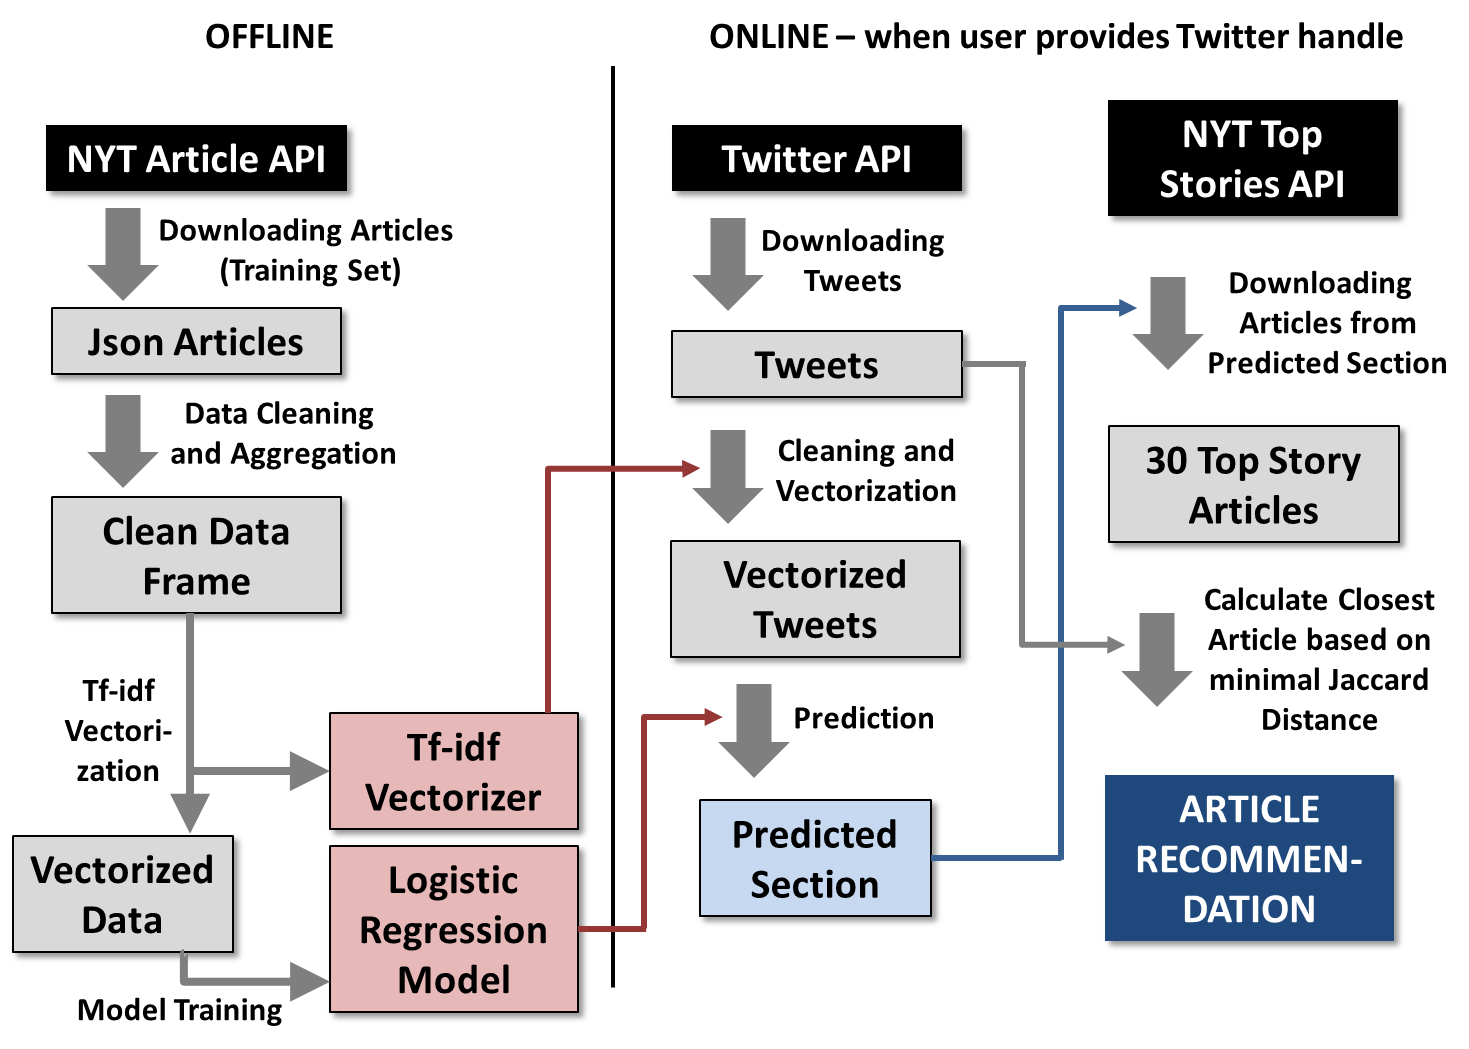

In [10]:
from IPython.display import Image
Image(filename='readlikeyoutweet_schematic.png', width=700) 

In the following, I will describe in detail all steps of the system ranging from the data collection to applying the fitted model.

### 2. Downloading New York Times articles via API 

The New York Times categorizes its content into 17 different sections (see http://www.nytimes.com/). 14 of them are defined by the content itself, like "Politics", or "Tech", while there are 3 sections, "Opinion", "Magazine", and "T Magazine", which deal with various topics and do not consist of regular news articles. We focus on the 14 well defined categories, which should cover the whole spectrum of what the NYT has to offer topicwise. An extension to also include the other categories could be done in another version of the recommender.

As a first step, I downloaded the articles from the New York Times, labeled with their sections. This was be done with their [Article Search API](http://developer.nytimes.com/docs/read/article_search_api_v2) (see *[src/articles.py](https://github.com/kkreis/ReadLikeYouTweet/blob/master/src/articles.py)* for the code). It offers, among many more options, the possibility to get articles filtered by sections and subsections. Unfortunately though, "Politics" is missing from the possible sections to look for. Therefore, to get articles about politics, instead of searching for the section, I searched for articles published by the politics newsdesk. However, there are many more newsdesks and by far not all politics articles are actually published by the politics newsdesk.

So, I downloaded all articles from the last 5 years while having a maximum of 10,000 articles per section. The API does not provide the complete article text, but only text pieces like the headline, the lead paragraph, the abstract, a text snippet, and a keyword list (there is more data, but it's not so useful for this project). As the abstract has often been missing in our data and its content is often identical or very much overlapping with the lead paragraph, I did not use it. The other four fields, **headline**, **lead paragraph**, **text snippet**, and **keyword list** were kept and used.

Since single letter words as well as numbers are typically not very predictive, I removed all punktuation, all single letters, all numbers, and also all other non-alphabetic characters and symbols in the data. Then, for each sample, all clean text data was combined into one long string consisting of only alphabetic words.

Finally, the data was saved in a bunch of json files, in total 131 MByte.

### 3. Aggregating and Analyzing the Data

(First some necessary imports, load the data, and set up a mapping of the numbered sections on their actual names)

In [1]:
from apikeyspath import PATH_TO_REPO
import pandas as pd
import numpy as np
import pickle
from sklearn.cross_validation import cross_val_score, train_test_split
import matplotlib
from matplotlib import pyplot as plt  
from matplotlib import rc
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sb
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from matplotlib import cm

In [5]:
data = pd.read_pickle(PATH_TO_REPO + "data/clean_nyt_training_data.pkl")

label_dict = {0: "Arts", 1: "Business", 2: "Food", 3: "Health", 4: "NY", 5: "Politics", 6: "RealEstate", 7: "Science", \
             8: "Sports", 9: "Style", 10: "Tech", 11: "Travel", 12: "US", 13: "World"}

In the next step, I combined all the data in the different json files into one large pandas dataframe. Furthermore, the data was shuffled and the word count for each sample was calculated (see *[src/datapreparation.py](https://github.com/kkreis/ReadLikeYouTweet/blob/master/src/datapreparation.py)* for the code). Then the clean data was saved as a pickled pandas dataframe.

So, let's do some basic analyses of our data to see what we deal with. 

#### 3.1 How man samples do we have in total?

In [3]:
len(data)

115327

We have 115,327 article samples. This is less than 140,000, which means that we did not get 10,000 articles for each section. 

#### 3.2 How many samples do we have per category?

In [4]:
data["category"] = data["label"].apply(lambda x: label_dict[x])

In [5]:
plot1data = data["label"].value_counts()
plot1frame = pd.DataFrame(plot1data)
plot1frame.rename(columns={0: 'Counts'}, inplace=True)
plot1frame = plot1frame.reset_index()
plot1frame.rename(columns={'index': 'label'}, inplace=True)
plot1frame["category"] = plot1frame["label"].apply(lambda x: label_dict[x])

In [6]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14) 
rcParams['figure.figsize'] = 13, 10

(0, 10500)

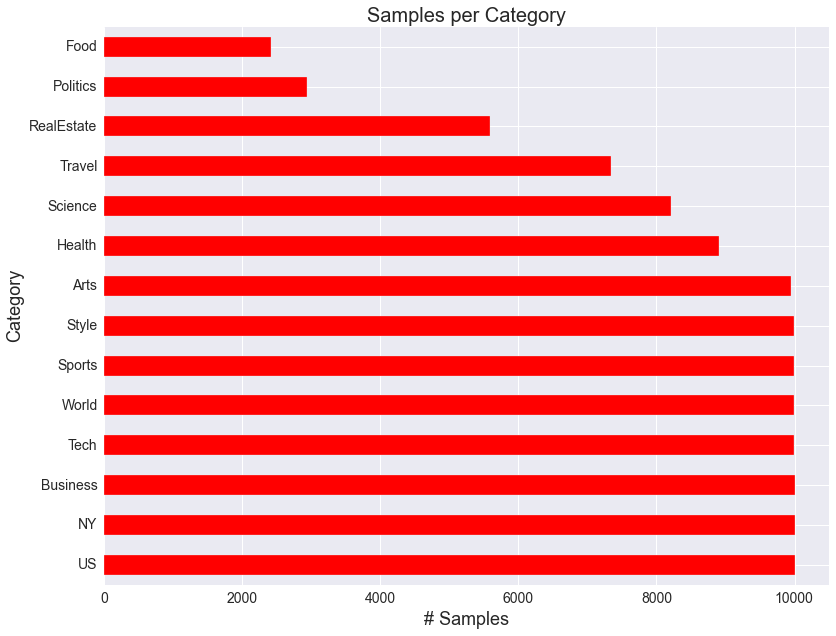

In [7]:
plot1frame.plot(x="category", y="Counts", kind='barh', rot=0, color="r")
plt.title('Samples per Category', fontsize=20)
plt.ylabel('Category', fontsize=18)
plt.xlabel('# Samples', fontsize=18)
ax = plt.gca()
ax.legend_ = None
ax.set_xlim([0, 10500])

For most categories we indeed have 10,000 samples. However, some have less, especially "Food" and "Politics". In the case of food, there are simply not many articles published, which makes sense. After all, the NYT is not exactly specialized on feed news. 

In the case of politics though, we now see that searching for newsdesks does by far not provide as many articles as searching for sections does. I could have gone further back than 5 years, but this seemed also dangerous. The patterns and predictive words may change over time and we want to have up to date data. Furthermore, roughly 3,000 articles about politics is not too bad after all. So, I decided to work with what I have.

#### 3.3 Another question about out data is, how many words do we actually have per sample? 

Let's make a stacked histogram of the wordscounts for the different sections.

In [8]:
plot2frame = pd.DataFrame()
for key, value in label_dict.iteritems():
    plot2frame[value] = data[data["label"]==key]["length"].value_counts()
plot2frame = plot2frame.sort_index()

(0, 150)

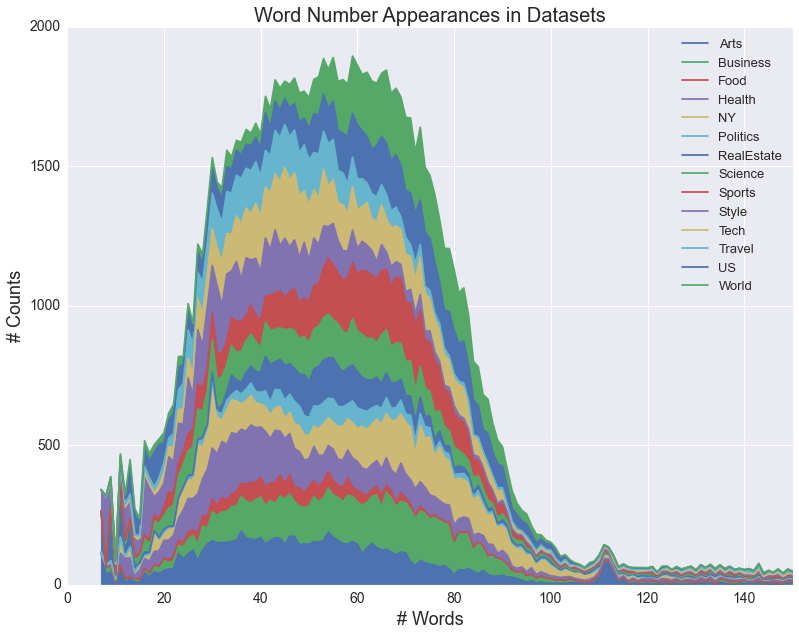

In [9]:
plot2frame.plot(kind='area')
plt.title('Word Number Appearances in Datasets', fontsize=20)
plt.ylabel('# Counts', fontsize=18)
plt.xlabel('# Words', fontsize=18)
ax = plt.gca()
ax.legend(fontsize=13)
ax.set_xlim([0, 150])

Most samples consist of word collections ranging between 20 and 100 words. However, we also have a few article samples with more and less words. Overall, the wordcount distributions are more or less similar for all the different categories. Only the arts section shows a little peak at around 110 words, which is not present in any of the other distributions.

### 4. Modeling the Data

Having prepared and polished the data, in the next step it was used as training data for the model (see *[src/algorithm.py](https://github.com/kkreis/ReadLikeYouTweet/blob/master/src/algorithm.py)* for the code). As a first step I vectorized the data with a term frequency-inverse document frequency vectorizer. All stopwords were removed, the maximal number of features was set on 10,000 and only unigrams were used. Furthermore, only words which appeared in more than 50 samples and less than 25% of all samples were considered.

The vectorized data was then used to fit the Logistic Regression classifier. To deal with the multiclass classification problem at hand, it used the one-vs-rest scheme with several different classifiers. Furthermore, for regularization the L2 norm was used with an inverse regularization strength of 1.0. Other values were tried but did not lead to improvements.

I also tried out a few different classification algorithms, like Naive Bayes and different ensemble methods. However, these did either not perform better than Logistic Regression or were computationally too demanding. 

After successfully fitting the model, the tf-idf vectorizer and the classifier were saved. 

Let us now have a closer look on the model.

In [ ]:
model = pickle.load(open(PATH_TO_REPO + "data/log_regression_model.pkl"))

In [ ]:
tfidf = pickle.load(open(PATH_TO_REPO + "data/tfidf_vectorizer.pkl"))

#### 4.1 Features and Coefficients

How many features/coefficients does the model have?

In [17]:
len(model.coef_[key])

7501

We have 7,501 features.  It's interesting to see which are the most decisive words for the different categories. Let's plot them.

In [12]:
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 

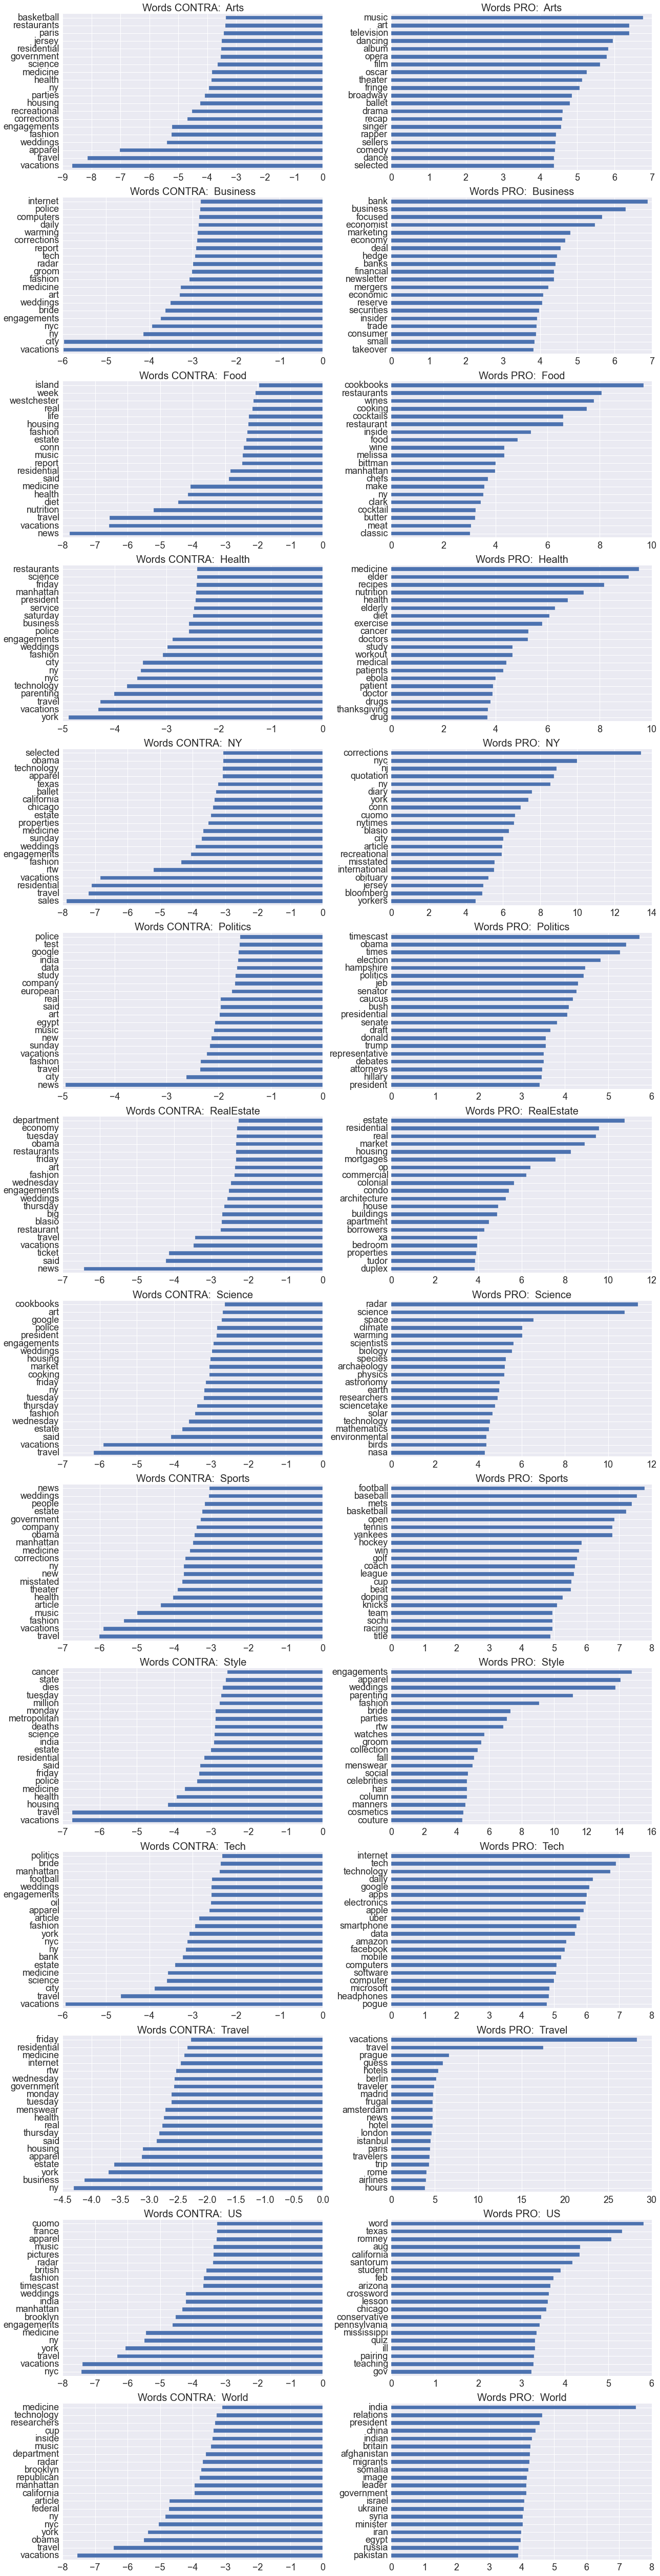

In [13]:
fig, axes = plt.subplots(14, 2, figsize=(18,70))
for key, value in label_dict.iteritems():
    coef = pd.Series(model.coef_[key], index=tfidf.get_feature_names())
    coef.sort()   
    coef[:20].plot(kind='barh', ax=axes[key,0])
    coef[-20:].plot(kind='barh', ax=axes[key,1])
    f = axes[key, 0].set_title("Words CONTRA:  " + value, fontsize = 20)
    f = axes[key, 1].set_title("Words PRO:  " + value, fontsize = 20)
f = plt.tight_layout()

Overall, it looks nice. Most words supporting certain categories make perfectly sense. However, there are exceptions: The most important word for the NY category is "corrections" and on position 4 in this section we have "quotation". These do not make much sense. Similarly, the word "word" is on position 1 for the US. It also seems that the US section is pretty broad and difficult to describe with a few keywords. However, overall the results seem satisfying.

#### 4.2 Scoring the Model

A more quantitative approach to evaluate the model is provided by scoring metrics. For the multiclass problem at hand, the most reasonable scoring functions to consider are the accuracy as well as the logloss.

As cross validating the model is computationally quite expensive, I only work with roughly half of the data we have. So, using only 70.000 samples, we reparametrize the tf-idf vectorizer and cross validate our model with accuracy and logloss as scoring functions:

In [18]:
X, y = tfidf.fit_transform(data.head(70000).allwords).todense(), data.head(70000).label

In [19]:
cross_val_score(model, X, y, cv=4, scoring='accuracy').mean()

0.79687165064436749

**Accuracy: 79.7% **

In [20]:
-cross_val_score(model, X, y, cv=4, scoring='log_loss').mean()

0.76703512132816909

**Logloss: 0.767**

To better interpret these numbers, let's compare them to the naive baselines:

### Accuracy

In this case, the naive baseline is given by always predicting one of the common categories. Hence the naive baseline accuracy is 10,000/115,327 = 0.087 = 8.7%. 

**Naive baseline of the accuracy: 8.7%**

### Logloss

The multiclass logloss is defined as

$$\text{logloss} = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{i,j} \log(p_{i,j})$$

for N samples and M different classes (sklearn uses natural logarithm with base e).

In this case, a naive classifier which would always predict one of the section would lead to a diverging logloss as $\text{log}(0) = -\infty$. A good naive classifier suited for the logloss would rather draw from a probability distribution similar to the distribution of our labels, but let's for our rough estimate consider one which predicts labels from a uniform distribution. Furthrmore, let's imagine our labels would also be equally distributed. Then $p_{i,j} = \frac{8,238}{115,327} = 0.071$ and $\log(p_{i,j}) = -2.645$ for all i and j. 

$y_{i,j}$ is one whenever it's real label for sample i does not correspond to the index j. In these cases we use $\log(p_{i,j})$ as penalty in the logloss. Hence, in our situation of naive prediction it is in 107,089 out of 115,327 cases one. Otherwise, it's zero. Then we sum over all samples and classes and normalize with the total number of samples. Hence, the logloss for always predict one common label would be $2.645 \times 14 \times \frac{107,089}{115,327}= 34.38$ (note that the perfect model would have 0 logloss). This is just an estimate, but the naive baseline of the logloss for drawing from a distribution according to the actual label distribution and for our actual data should be of the same order of magnitude. 

**Estimate for the naive baseline of the logloss: 34.38**

### Our Scores

It seems like we are doing not too bad. Predicting correctly in about 80% of all cases seems good when having 14 different labels and a naive baseline accuracy of 8.7%. Similarly, a logloss of 0.767 also seems quite good compared to the baseline of 34.38. Furthermore, when using the full dataset for training, the scores would be probably even higher.

#### 4.3 Confusion Matrix

Let's also have a look at the confusion matrix. Of course, I don't want to cheat by looking at the same data I used to fit the model. Therefore, let's use half of the dataset to refit the algorithm and the other half for testing and calculating the confusion matrix.

In [12]:
data_train, data_test = train_test_split(data, test_size=0.5)

In [17]:
X_train, y_train = tfidf.fit_transform(data_train.allwords).todense(), data_train.label

In [18]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [19]:
X_test, y_test = tfidf.transform(data_test.allwords).todense(), data_test.label

In [20]:
y_pred = model.predict(X_test)

In [21]:
cmatrix = confusion_matrix(y_test, y_pred)
print cmatrix

[[4223   60    1   16  144    6   11   48  105   87   72   21  148   73]
 [ 179 3604    9  100   46   15   50   81   48   54  413   39  171  222]
 [  22    8  923   38   86    1    6   12    8   61    6   14   22    8]
 [  36   68   26 3730   33    8    4  230   27   50   45   11  117   39]
 [ 297   77  104   54 3667   16  158   52   94   80   38   19  191  109]
 [  14   22    0   12   23  696    1   16    4    4   10    4  588   41]
 [  22   39    0    3  140    0 2545   17    5   10   11   12   16    3]
 [  50   59    2  467   82    6    9 3064   20   33   79   21  127   71]
 [  41   30    1   16   28    0    0   10 4663   17    6    2   62   51]
 [ 226   52   94   87  157    6   19   37   55 4080   73   41   85   26]
 [  74  292    4   34   26    8    4   80   22   39 4201   29   93  102]
 [ 118   33   14    4   44    0    6   34   24   65   36 3233   44   24]
 [ 162  212    5  125  198  243   25  169  120   59   97   29 3273  309]
 [ 107  218    8   63   54    8    9   64   44   27

Well, this looks ugly, let's plot it in colors.

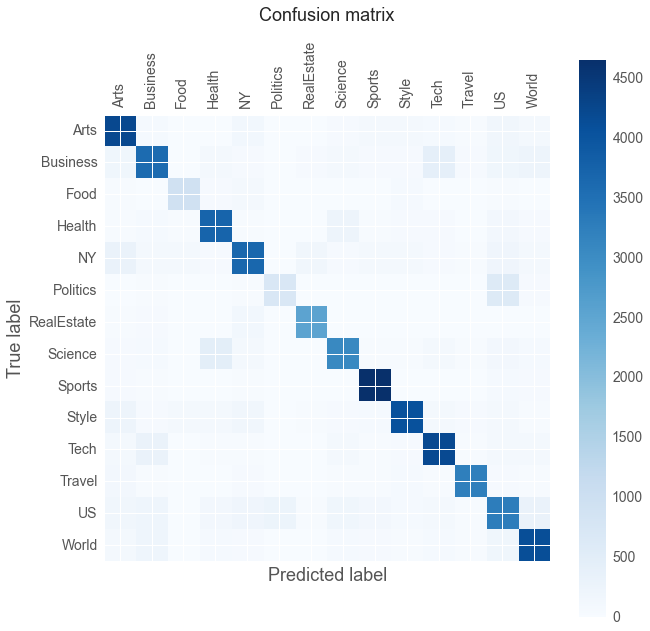

In [22]:
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14) 
rcParams['figure.figsize'] = 13, 10
plt.matshow(cmatrix, cmap=cm.Blues)
plt.title('Confusion matrix', fontsize=18, y=1.2)
plt.colorbar(cmap=cm.Blues)
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.xticks(np.arange(0, 14, 1), rotation=90)
plt.yticks(np.arange(0, 14, 1))
ax = plt.gca()
labels = [item.get_text() for item in ax.get_xticklabels()]
for key, val in label_dict.iteritems():
    labels[int(key)] = val
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

This does not look too bad. Note that in the cases for "Food" and "Politics" there are simply significantly less samples overall. Therefore, they appear lighter in the plot. This does not necessarily mean that they are predicted worse than the others. However, in the case of "Politics" it's visible that many of its articles get classified as "US". This should not be a too big problem though, as "US" and "Politics" are very related topics anyways and it should not matter too much whether Twitter users are classified as interested in "US" or "Politics". After all, many "US" articles are also dealing with political issues.

Similar but lower correlations can also be observed between "Tech" and "Business", "Science" and "Health", as well as "NY" and "Arts".

Also note that the performance of the algorithm when using the whole dataset would certainly be even better, especially for the politics section where we have only few samples. 

Finally, I want to point out that all successful analyzes above do not necessarily mean that our model also works as good on tweets and the users' interests as it does on articles and sections. However, we can expect at least reasonable performance, considering these promising results so far. Something to note at this point is that the model naturally fails if the user does not tweet in English, as the articles used for training the algorithm are all written in English. Therefore, the engine targets only English twitterers. 

### 5. Prediction

Having fitted the model, we can now use it for predicting Twitter users' interests and for recommending articles (see *[src/predictor.py](https://github.com/kkreis/ReadLikeYouTweet/blob/master/src/predictor.py)* for the code). The recommendation engine performs several steps when a Twitter handle is provided.

#### 5.1 Predicting the Section

First, the tweets are downloaded and the section is predicted:

1. When a user provides his Twitter handle the system connects to the [Twitter API](https://dev.twitter.com/overview/api) and downloads the user's latest 100 tweets.
2. Using the previously parametrized tf-idf vectorizer the tweets are processed and vectorized as the article data was before.
3. Then, for each tweet we use the Logistic Regression model to predict which section this tweet would correspond to, or, in other words, which interest, defined by the sections, this tweet could be associated with.
4. Finally, the section which is predicted most often, is considered to be the section the user is most interested in.

#### 5.2 Article Recommendation

Then, the following is happening:

1. The system connects to the [Top Stories API](http://developer.nytimes.com/docs/read/top_stories_api), which provides the 30 latest top story articles from a given section. We get the top stories from the section previously predicted by the classifier. However, from these articles, we do not get the whole text, but the titles, abstracts, as well as section and keyword data.
2. Both all of the users tweets as well as the data for each of the 30 articles are cleaned from any non-alphabetic characters, stopwords and single letters. Then, all words in the clean tweets are aggregated in one list and also for each article a word list is created.
3. These lists are converted into sets removing duplicates and the Jaccard distances between the tweet data and all articles are calculated.
    * The Jaccard Distance between two sets A and B is defined as:
$$J(A,B) = 1- \frac{A\cap B}{A\cup B}$$
        where $A\cap B$ is the intersection between the two sets, that is, the number of words both sets have in common, and $A\cup B$ is the union of the two sets, that is, the total number of different words in the two sets. Two identical sets have 0 distance, as their union and intersection are identical, while two completely different sets with zero intersection have Jaccard distance 1.        
<br>
4. Finally, the article closest to the user's tweets is recommended.

### 6. Outlook

Of course, there are many options to further improve and extend the developed article recommender system. Some of them include:

* Try to fit a stronger model, possibly using other classifiers
* Use dimensionality reduction or clustering techniques to gain further insights and/or reduce features
* Predict several probable labels and do not only recommend from one section but from several probable ones
* Scrape whole articles using webscraping tools like beautifulsoup to get whole articles instead of only headlines, snippets and keywords. This could maybe help when training the algorithm and when calculating the Jaccard distances
* Include further newspapers other than the New York Times, both for model training as well as recommendation (use for example also the Guardian, which also has a great API framework)
* Check where the user comes from (UK, US, Australia) and recommend either from NYT/Guardian US, Guardian UK, or Guardian Australia
* Extend the system beyond targeting only English twitterers and recommending only English newspaper articles
* Try to get even more user information, for example from Facebook, LinkedIn, etc., to make even better recommendations

### 7. Conclusions

In conclusion, I could set up a first working version of an article recommendation system that suggests New York Times articles to English Twitter users based on their tweets. As for many recommendation systems, the model works well when there is a lot of data available, in this case tweets, and when this data is consistent and not too noisy, which means that most of the tweets would belong to the same category. This is of course not always the case, but often nevertheless a reasonable recommendation can be made.